In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
#source('tests.R')
#source("cleanup.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

# Prediction to the risk of heart attack 

### INTRODUCTION
Heart attack happens when a part of the heart muscle doesn’t get enough blood. Nowadays, heart attack is a common and deadly disease across the world. In a year, millions of people suffer from heart attacks that mostly result in death. As a result, more and more people are paying attention to this matter. Therefore, if we can predict someone with a high risk of heart attack beforehand, it may save his/her life by taking some quick medical treatment and changing their lifestyle! 

In this project, we are trying to predict whether someone has a high risk of getting a heart attack or not. We will analyze numerous data in a dataset with various factors that may influence the risks of getting heart attack.

The heart attack data is imported from UCI machine learning repository, written in .tsv format. The dataset contains 294 rows and 14 columns(variables). Those variables come in different types, such as binary, categorical, and double. One of the variables, which is “num”, is what we are trying to predict. The values of the “num” column are either 1 (high risk) or 0 (low risk), in which the number of both values are approximately the same (both classifications are spread evenly). The information in the dataset that we use is collected from Hungaria.

### Preliminary exploratory data analysis

In [22]:
heart_attack_data_raw = read_csv("https://raw.githubusercontent.com/RichardAdhika22/group115/main/processed.hungarian%20(1).data",
                                ,col_names=FALSE)
colnames(heart_attack_data_raw) = c('age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num')
heart_attack_data_raw = heart_attack_data_raw |>
    select(-slope, -ca, -thal)

# find elements
idx <- heart_attack_data_raw == "?"
# replace elements with NA
is.na(heart_attack_data_raw) <- idx

drop_na(heart_attack_data_raw, age:num)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,num
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
28,1,2,130,132,0,2,185,0,0,0
29,1,2,120,243,0,0,160,0,0,0
30,0,1,170,237,0,1,170,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,1
58,0,2,180,393,0,0,110,1,1,1
65,1,4,130,275,0,1,115,1,1,1


In [23]:
heart_attack_data = select(heart_attack_data_raw,sex,trestbps,chol,thalach,cp,num)
#heart_attack_data = mutate(heart_attack_data,cp=as.factor(cp),num=as.factor(num))
heart_attack_data

sex,trestbps,chol,thalach,cp,num
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,130,132,185,2,0
1,120,243,160,2,0
1,140,NA,170,2,0
⋮,⋮,⋮,⋮,⋮,⋮
1,155,342,150,4,1
0,180,393,110,2,1
1,130,275,115,4,1


In [4]:
table_means = select(heart_attack_data,-sex) |>
group_by(num) |>
summarize(across(trestbps:cp,mean))
colnames(table_means) = c('num',"mean terstbps","mean chol","mean thalach","mean cp")
table_means

Warning message in mean.default(trestbps):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(trestbps):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(chol):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(chol):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(thalach):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(thalach):
“argument is not numeric or logical: returning NA”


num,mean terstbps,mean chol,mean thalach,mean cp
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,NA,NA,NA,2.617021
1,NA,NA,NA,3.632075


In [5]:
table_num_count = heart_attack_data |>
group_by(num) |>
summarize("total amount of num"=n())
table_num_count
num_count_col = pull(table_num_count, 'total amount of num')
num_count_col

num,total amount of num
<dbl>,<int>
0,188
1,106


[1] 188 106

In [6]:
summary_table = bind_cols(table_means,num_count_col)
colnames(summary_table) = c('num',"mean terstbps","mean chol","mean thalach","mean cp","total count of num")
summary_table

New names:
• `` -> `...6`


num,mean terstbps,mean chol,mean thalach,mean cp,total count of num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,NA,NA,NA,2.617021,188
1,NA,NA,NA,3.632075,106


In [7]:
#Visualizations

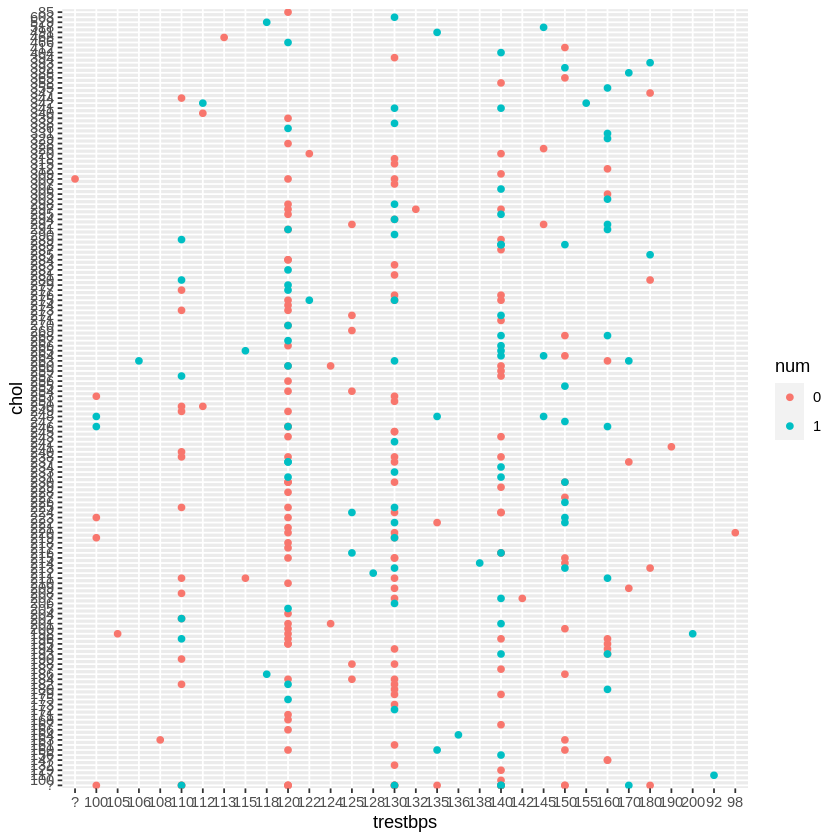

In [8]:
heart_attack_data_factored = mutate(heart_attack_data_raw,num=as.factor(num))
ggplot(heart_attack_data_factored,aes(x=trestbps,y=chol,color=num))+
geom_point()

### Methods

Steps of doing the classification prediction:
1. Download and read the dataset.
2. Select and filter the columns that we want to use.
3. Separate the dataset into a training set and a testing set.
4. Create the workflow with cross-validation method and various values of k to find out which k is the best option to be used.
5. Calculate the average accuracy for each k and pick the highest amongst them.
6. Use the value k that we have analyzed to make our final prediction.
7. Testing our prediction accuracy by examining our testing set.
8. Make visualization.

Columns/Variables as predictor variables:
We choose these 4 variables as our predictors with all of them having the “double” type, so that the prediction will be more reasonable and accurate compared to the factor type. 
* Age in years
* Resting blood pressure in mmHg (trestbps)
* Cholesterol in mg/dl fetched by BMI sensor (chol)
* Maximum heart rate achieved (thalach)
* ST depression induced by exercise relative to rest (oldpeak)

One way to visualize the results of prediction is to make a line plot on how different values of K affect the accuration of the prediction so that we can choose the K that has the highest accuracy. Another visualization we plan to make is a scatter plot showing the relationship between two of the predictor variables we are interested in. Then, we can separate the plot into two regions with different colors to mark each factor from our prediction result. 


### Expected outcomes and significance

By building a prediction of the risk of heart attack, not only can we calculate the accuracy of our prediction, but we can also find out whether those four predictor variables that we chose are suitable in our model or not. Low accuracy of prediction means that we should do something about the predictor variables (assuming the data itself is accurate) by changing the variables that we use (add and/or reduce variables). 

Doing the prediction of the risk of heart attack may save people’s lives. Some people might not realize that they have a high risk heart attack until they have a medical check-up. After knowing it, they can take some medication and change their lifestyle to reduce the risk of getting a heart attack. In another case, people who find out that they have a low risk of getting a heart attack might reduce their worry about getting this disease, but still should maintain their healthy lifestyle.

Some questions that might appear in the future regarding this prediction: 
* Are there any additional predictor variables to be added into consideration when predicting the risk of heart attack?
* Is the accuracy of this prediction high enough to be used in a real world situation?
